<a href="https://colab.research.google.com/github/kosamate/brain-tumor-segmentation/blob/main/brain_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Set up kaggle creditentals.

In [ ]:
import os
import pathlib
DRIVE_PATH = pathlib.Path("/content/drive/MyDrive/brain")
!pip install -r "/content/drive/MyDrive/brain/requirements.txt"
os.environ['KAGGLE_USERNAME'] = "" # add your username
os.environ['KAGGLE_KEY'] = "" # add your kaggle key

Downlaod the content of dataset

In [ ]:
import kaggle

kaggle.api.authenticate()

kaggle.api.dataset_download_files('mateuszbuda/lgg-mri-segmentation', path='/content/data', unzip=True, quiet=True)

Dataset URL: https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation


Define the hyperparameters for the whole training process.

In [ ]:
import pathlib
import torch
class HyperParameters():
  BATCH_SIZE = 16
  IMAGE_SIZE = 256
  EPOCHS = 15
  LEARNING_RATE = 0.0002
  WEIGHTS_PATH = DRIVE_PATH

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")


device: cuda:0


Define the transformation.

In [ ]:
from torchvision.transforms import v2
import torch

transform = v2.Compose([
    v2.ToTensor(),
    v2.Resize((256, 256)),
])
# TODO: Augemntation may be needed

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Define a dataset.

In [ ]:
from typing import NamedTuple
from torch.utils.data import Dataset
import pathlib
import skimage.io
import numpy as np
from torchvision.transforms import v2

class SliceInfo(NamedTuple):
  image: pathlib.Path
  mask: pathlib.Path

class BrainImageDataset(Dataset):
  def __init__(self, path: pathlib.Path, transfrom: v2.Transform) -> None:
    self._slices: list[SliceInfo] = []
    self._transform = transform

    for patient_dir in path.glob("TCGA*"):
      for mask_image in patient_dir.glob("*_mask.tif"):
        image_path = pathlib.Path(mask_image.as_posix().replace("_mask",""))
        slice_info = SliceInfo(image_path, mask_image)
        self._slices.append(slice_info)
    self._slices.sort(key=lambda i: i.image.name)

  def __getitem__(self, index) -> tuple:
    image_path, mask_path = self._slices[index]
    image = skimage.io.imread(image_path)
    mask = skimage.io.imread(mask_path, as_gray=True)

    image = np.array(image)
    mask = np.array(mask)
    info = image_path.name.split("/")[-1]

    image, mask = self._transform(image, mask)
    mask = mask[0,:,:].view((1, 256, 256))
    return image, mask, info

  def __len__(self) -> int:
    return len(self._slices)


image_ds = BrainImageDataset(pathlib.Path("/content/data/kaggle_3m"), transform)
print(len(image_ds))

3929


Helper functions to visualize the data and the result.

In [ ]:
from operator import imod
import matplotlib.pyplot as plt
import matplotlib.patches
import torch
import torch.nn as nn

def show_image(image_ds: BrainImageDataset, index: int) -> None:
    plt.imshow(np.squeeze(image_ds[index][0]).T)
    plt.title(image_ds[index][2])

def show_mask(image_ds: BrainImageDataset, index: int) -> None:
    plt.imshow(np.squeeze(image_ds[index][1]).T, cmap="gray")
    plt.title(image_ds[index][2])

def show_prediction(image_ds: BrainImageDataset,
                    index: int,
                    net: nn.Module,
                    threshold=0.8) -> None:
    fig, ax = plt.subplots(2, 2)

    ax[0, 0].imshow(np.squeeze(image_ds[index][0]).T)
    ax[0, 0].set_title(image_ds[index][2])
    _remove_ticklabels(ax[0, 0])

    true = np.squeeze(image_ds[index][1]).T
    ax[0, 1].imshow(true, cmap="gray")
    ax[0, 1].set_title("ground truth")
    _remove_ticklabels(ax[0, 1])

    x = image_ds[index][0].view((1,3,256,256)).to(device)
    with torch.no_grad():
        preds = net(x)
    prediction = preds.detach().cpu().numpy()
    prediction = np.squeeze(prediction[0]).T
    ax[1, 0].imshow(prediction, cmap="gray")
    ax[1, 0].set_title("prediction")
    _remove_ticklabels(ax[1, 0])

    empty_image_rgb = np.zeros((256, 256, 3), dtype=np.uint8)
    for i in range(0, 256):
      for j in range(0, 256):
        if true[i, j] > 0.5:
          empty_image_rgb[i, j, 0] = 255
        if prediction[i, j] > threshold:
          empty_image_rgb[i, j, 1] = 255


    ax[1, 1].imshow(empty_image_rgb)
    ax[1, 1].set_title("prediction overlay")
    ax[1, 1].text(-120, 20, "ground truth", color="red", fontsize=8)
    ax[1, 1].text(-120, 35, "prediction", color="green", fontsize=8)
    ax[1, 1].text(-120, 50, "overlay", color="yellow", fontsize=8)
    _remove_ticklabels(ax[1, 1])

def show_segmentation(
    image_ds: BrainImageDataset,
    index: int,
    net: nn.Module,
    threshold=0.8
):
    image_rgb = np.zeros((256, 256, 3), dtype=np.uint8)
    brain_image = np.squeeze(image_ds[index][0]).T
    brain_mask = np.squeeze(image_ds[index][1]).T
    input = image_ds[index][0].view((1,3,256,256)).to(device)
    with torch.no_grad():
        preds = net(input)
    prediction = preds.detach().cpu().numpy()
    prediction = np.squeeze(prediction[0]).T
    image_rgb[:, :, 0] = brain_image[:, :, 1] * 255
    image_rgb[:, :, 1] = brain_image[:, :, 1] * 255
    image_rgb[:, :, 2] = brain_image[:, :, 1] * 255

    for i in range(0, 256):
        for j in range(0, 256):
            _draw_outline(brain_mask, image_rgb, i, j, color="red")
            _draw_outline(prediction, image_rgb, i, j, color="green", th=threshold)

    plt.imshow(image_rgb)
    plt.title(image_ds[index][2])

def _remove_ticklabels(ax) -> None:
    ax.set_yticklabels([])
    ax.set_xticklabels([])

def _draw_outline(mask, output, i ,j, color, th=0.5):
    channel = 0
    if color == "green":
        channel = 1
    if color == "blue":
        channel = 2
    if mask[i, j] > th:
        if i == 0 or j == 0 or i == 255 or j == 255:
            output[i, j, channel] = 255
        elif (mask[i-1, j] < th or mask[i+1, j] < th or
              mask[i, j-1] < th or mask[i, j+1] < th):
            output[i, j, channel] = 255


Load a previously saved model

In [ ]:
import torch
net = BrainSegmentationModel()
net.load_state_dict(torch.load(HyperParameters.WEIGHTS_PATH / "secondUNet.pt", weights_only=True))
net.to(device)
print("Model loaded")

Model loaded


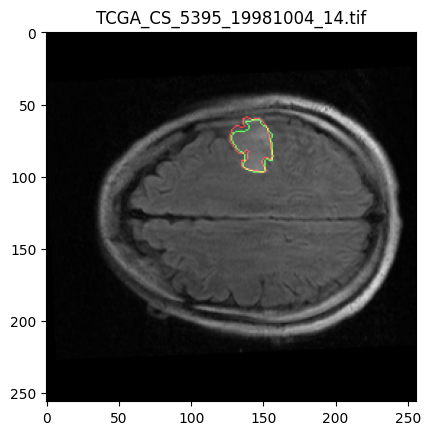

In [ ]:
show_segmentation(image_ds, 108, net, threshold=0.9)

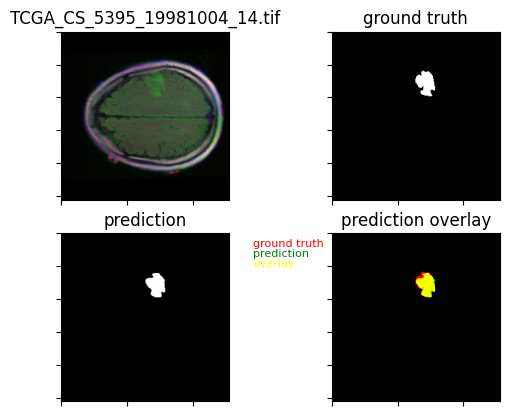

In [ ]:
show_prediction(image_ds, 108, net, threshold=0.9)

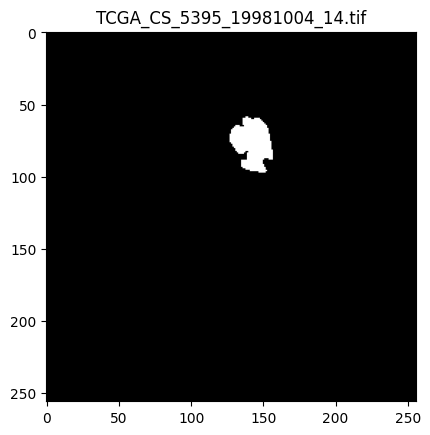

In [ ]:
show_mask(image_ds, 108)

In [ ]:
import torch
from torch.utils.data import DataLoader

train_ds, test_ds, val_ds = torch.utils.data.random_split(image_ds, [3000, 500, 429],generator=torch.Generator().manual_seed(42))

train_dl = DataLoader(dataset=train_ds, batch_size=HyperParameters.BATCH_SIZE, shuffle=True)

test_dl = DataLoader(dataset=test_ds, batch_size=HyperParameters.BATCH_SIZE, shuffle=False)

val_dl = DataLoader(dataset=val_ds, batch_size=HyperParameters.BATCH_SIZE, shuffle=False)

Define a model for the image segmentation.

In [ ]:
import collections
import torch
import torch.nn as nn

class BrainSegmentationModel(nn.Module):
  def __init__(self) -> None:
    super().__init__()
    features = 32
    self.encoder1 = BrainSegmentationModel._block(3, features, name="enc1")
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.encoder2 = BrainSegmentationModel._block(features, features * 2, name="enc2")
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.encoder3 = BrainSegmentationModel._block(features * 2, features * 4, name="enc3")
    self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.encoder4 = BrainSegmentationModel._block(features * 4, features * 8, name="enc4")
    self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.bottleneck = BrainSegmentationModel._block(features * 8, features * 16, name="bottleneck")

    self.upconv4 = nn.ConvTranspose2d(
        features * 16, features * 8, kernel_size=2, stride=2
    )
    self.decoder4 = BrainSegmentationModel._block((features * 8) * 2, features * 8, name="dec4")
    self.upconv3 = nn.ConvTranspose2d(
        features * 8, features * 4, kernel_size=2, stride=2
    )
    self.decoder3 = BrainSegmentationModel._block((features * 4) * 2, features * 4, name="dec3")
    self.upconv2 = nn.ConvTranspose2d(
        features * 4, features * 2, kernel_size=2, stride=2
    )
    self.decoder2 = BrainSegmentationModel._block((features * 2) * 2, features * 2, name="dec2")
    self.upconv1 = nn.ConvTranspose2d(
        features * 2, features, kernel_size=2, stride=2
    )
    self.decoder1 = BrainSegmentationModel._block(features * 2, features, name="dec1")

    self.conv = nn.Conv2d(
        in_channels=features, out_channels=1, kernel_size=1
    )

  def forward(self, x):
      enc1 = self.encoder1(x)
      enc2 = self.encoder2(self.pool1(enc1))
      enc3 = self.encoder3(self.pool2(enc2))
      enc4 = self.encoder4(self.pool3(enc3))

      bottleneck = self.bottleneck(self.pool4(enc4))

      dec4 = self.upconv4(bottleneck)
      dec4 = torch.cat((dec4, enc4), dim=1)
      dec4 = self.decoder4(dec4)
      dec3 = self.upconv3(dec4)
      dec3 = torch.cat((dec3, enc3), dim=1)
      dec3 = self.decoder3(dec3)
      dec2 = self.upconv2(dec3)
      dec2 = torch.cat((dec2, enc2), dim=1)
      dec2 = self.decoder2(dec2)
      dec1 = self.upconv1(dec2)
      dec1 = torch.cat((dec1, enc1), dim=1)
      dec1 = self.decoder1(dec1)
      return torch.sigmoid(self.conv(dec1))

  @staticmethod
  def _block(in_channels, features, name):
      return nn.Sequential(
          collections.OrderedDict(
              [
                  (
                      name + "conv1",
                      nn.Conv2d(
                          in_channels=in_channels,
                          out_channels=features,
                          kernel_size=3,
                          padding=1,
                          bias=False,
                      ),
                  ),
                  (name + "norm1", nn.BatchNorm2d(num_features=features)),
                  (name + "relu1", nn.ReLU(inplace=True)),
                  (
                      name + "conv2",
                      nn.Conv2d(
                          in_channels=features,
                          out_channels=features,
                          kernel_size=3,
                          padding=1,
                          bias=False,
                      ),
                  ),
                  (name + "norm2", nn.BatchNorm2d(num_features=features)),
                  (name + "relu2", nn.ReLU(inplace=True)),
              ]
          )
      )

Define lossses for the segmentation.

In [ ]:
import torch.nn as nn

class DiceLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.smooth = 1.0

    def forward(self, y_pred, y_true):
        assert y_pred.size() == y_true.size(), f"pred: {y_pred.size()}, true: {y_true.size()}"
        y_pred = y_pred[:, 0].contiguous().view(-1)
        y_true = y_true[:, 0].contiguous().view(-1)
        intersection = (y_pred * y_true).sum()
        dsc = (2.0 * intersection + self.smooth) / (y_pred.sum() + y_true.sum() + self.smooth)
        return 1.0 - dsc

class IoULoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.smooth = 1.0

    def forward(self, y_pred, y_true):
        assert y_pred.size() == y_true.size()
        y_pred = y_pred[:, 0].contiguous().view(-1)
        y_true = y_true[:, 0].contiguous().view(-1)
        iou = ((y_pred * y_true).sum() + self.smooth) / (y_pred + y_true).sum()
        return 1.0 - iou

Everything is defined or initialize to start the trainning.

In [ ]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")
net = BrainSegmentationModel()
net.to(device)

loss_func = IoULoss()
loss_func.to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=HyperParameters.LEARNING_RATE)

device: cuda:0


In [ ]:
# logger = Logger(args.logs)
!pip install medpy
from medpy.filter.binary import largest_connected_component
def dsc_per_volume(validation_pred, validation_true, patient_slice_index):
    dsc_list = []
    num_slices = np.bincount([p[0] for p in patient_slice_index])
    index = 0
    for p in range(len(num_slices)):
        y_pred = np.array(validation_pred[index : index + num_slices[p]])
        y_true = np.array(validation_true[index : index + num_slices[p]])
        dsc_list.append(dsc(y_pred, y_true))
        index += num_slices[p]
    return dsc_list

def dsc(y_pred, y_true, lcc=True):
    if lcc and np.any(y_pred):
        y_pred = np.round(y_pred).astype(int)
        y_true = np.round(y_true).astype(int)
        y_pred = largest_connected_component(y_pred)
    return np.sum(y_pred[y_true == 1]) * 2.0 / (np.sum(y_pred) + np.sum(y_true))

def log_summary(loss_list: list[float], prefix=""):
    print(f"{prefix}loss: {np.mean(loss_list)}\n")

loaders = {"train": train_dl, "valid": val_dl}
loss_train = []
loss_valid = []
history: dict[str, list[float]] = {"train": [], "valid": []}

step = 0
best_validation_dsc = 0

for epoch in range(HyperParameters.EPOCHS):
    print(f"===== EPOCH{epoch} =====\n")
    for phase in ["train", "valid"]:
        if phase == "train":
            net.train()
        else:
            net.eval()
        print(f"Phase: {phase}\n")

        validation_pred = []
        validation_true = []

        for i, data in enumerate(loaders[phase]):
            if phase == "train":
                step += 1

            x, y_true, _ = data
            x, y_true = x.to(device), y_true.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == "train"):
                y_pred = net(x)

                loss = loss_func(y_pred, y_true)

                if phase == "valid":
                    loss_valid.append(loss.item())
                    y_pred_np = y_pred.detach().cpu().numpy()
                    validation_pred.extend(
                        [y_pred_np[s] for s in range(y_pred_np.shape[0])]
                    )
                    y_true_np = y_true.detach().cpu().numpy()
                    validation_true.extend(
                        [y_true_np[s] for s in range(y_true_np.shape[0])]
                    )
                    # if (epoch % args.vis_freq == 0) or (epoch == HyperParameters.EPOCHS - 1):
                    #     if i * HyperParameters.BATCH_SIZE < args.vis_images:
                    #         tag = "image/{}".format(i)
                    #         num_images = args.vis_images - i * HyperParameters.BATCH_SIZE
                    #         logger.image_list_summary(
                    #             tag,
                    #             log_images(x, y_true, y_pred)[:num_images],
                    #             step,
                    #         )

                if phase == "train":
                    loss_train.append(loss.item())
                    loss.backward()
                    optimizer.step()

            # if phase == "train" and (step + 1) % 10 == 0:
            #   log_summary(loss_train, step)
            #   # log_loss_summary(logger, loss_train, step)
            #   # loss_train = []

        if phase == "train":
            log_summary(loss_train, prefix="train_")
            history["train"].append(np.mean(loss_train))
            loss_train = []

        if phase == "valid":
        #     # log_loss_summary(logger, loss_valid, step, prefix="val_")
        #     mean_dsc = np.mean(
        #         dsc_per_volume(
        #             validation_pred,
        #             validation_true,
        #             val_dl.dataset.patient_slice_index,
        #         )
        #     )
        #     # logger.scalar_summary("val_dsc", mean_dsc, step)
        #     if mean_dsc > best_validation_dsc:
        #         best_validation_dsc = mean_dsc
        #         torch.save(net.state_dict(), HyperParameters.WEIGHTS_PATH / "unet.pt")
            log_summary(loss_valid, prefix="val_")
            history["valid"].append(np.mean(loss_valid))
            loss_valid = []

print("Best validation mean DSC: {:4f}".format(best_validation_dsc))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.3/156.3 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 MB 16.7 MB/s eta 0:00:00
  Created wheel for medpy: filename=MedPy-0.5.2-cp310-cp310-linux_x86_64.whl size=762840 sha256=4080aaec5272e2070824c1c1cf6e2eef0334c6360c9036a2bad95213e68a56dc
  Stored in directory: /root/.cache/pip/wheels/a1/b8/63/bdf557940ec60d1b8822e73ff9fbe7727ac19f009d46b5d175
Successfully built medpy
===== EPOCH0 =====

Phase: train

train_loss: 0.9717139151502163

Phase: valid

val_loss: 0.969698636620133

===== EPOCH1 =====

Phase: train

train_loss: 0.956132728685724

Phase: valid

val_loss: 0.9500401969309207

===== EPOCH2 =====

Phase: train

train_loss: 0.9303346472851773

Phase: valid

val_loss: 0.9177082556265371

===== EPOCH3 =====

Phase: train

train_loss: 0.8819567053876025

Phase: valid

val_loss: 0.8577272428406609

===== EPOCH4 =====

Phase: train

train_loss: 0.8098531923395522

P

Plot training loss

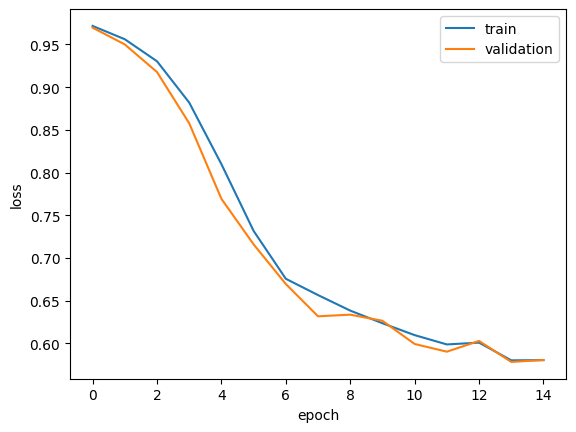

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history["train"], label="train")
plt.plot(history["valid"], label="validation")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

In [ ]:
dice_loss = DiceLoss()
iou_loss = IoULoss()

test_dice_loss = []
test_iou_loss = []
for i, data in enumerate(test_dl):
  x, y_true, _ = data
  x, y_true = x.to(device), y_true.to(device)
  with torch.no_grad():
    y_pred = net(x)
    loss = dice_loss(y_pred, y_true)
    test_dice_loss.append(loss.item())
    loss = iou_loss(y_pred, y_true)
    test_iou_loss.append(loss.item())
print(f"iou loss: {np.mean(test_iou_loss)}, dice loss: {np.mean(test_dice_loss)}")

iou loss: 0.5920907743275166, dice loss: 0.18442422337830067


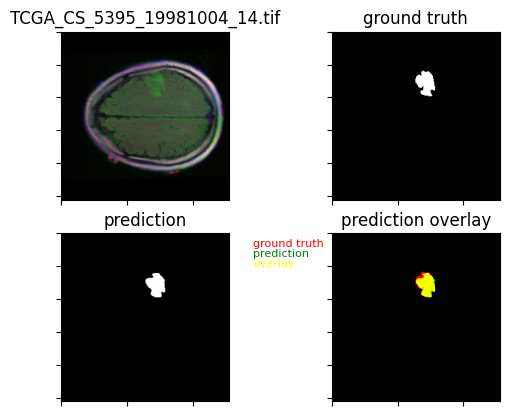

In [ ]:
show_prediction(image_ds, 108, net, threshold=0.9)

In [ ]:
torch.save(net.state_dict(), HyperParameters.WEIGHTS_PATH / "thirdUNet.pt")